In [8]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg
%matplotlib inline

In [9]:
def read_txt(datafile):
    with open(datafile, "r") as file:
        lines = file.readlines()
        data = [[float(num) for num in line.split()] for line in lines]
    return data

In [10]:
def dynamics(dt, state, RW, w_input_noise, a_input_noise, sf):
    state_next = np.zeros(9) 
    state_next[0:3] = state[0:3] + state[3:6] * dt + RW * np.random.randn(3)           # omega
    state_next[3:6] = w_input_noise * np.random.randn(3)                               # omega_dot
    state_next[6:9] = sf + a_input_noise * np.random.randn(3)                          # specific force
    return state_next

def dynamics_est(dt, state, sf):
    state_next = np.zeros((len(state), 9))
    for i in range(len(state)):
        state_next[i,0:3] = state[i,0:3] + state[i,3:6] * dt          # omega
        state_next[i,3:6] = np.zeros(3)                           # omega_dot
        state_next[i,6:9] = sf                                    # specific force
    return state_next

In [11]:
def wedge(a):
    Ahat = np.array([[0, -a[2], a[1]],
                    [a[2], 0, -a[0]],
                    [-a[1], a[0], 0]])
    return Ahat

def measurement(state, pos_r, Rb_si, WN, num_imus):
    meas = np.zeros(6*num_imus)
    for i in range(num_imus):
        Rb_si_sub = Rb_si[i]
        r_sub = pos_r[i]
        sf = state[6:9]
        omega = state[0:3]
        omega_dot = state[3:6]
        RW_sub = state[9+i:15+6*i]
        s_i = Rb_si_sub @ (sf + wedge(omega) @ wedge(omega) @ r_sub + wedge(omega_dot) @ r_sub + WN[i*num_imus:3+i*num_imus]*np.random.randn(3)) + RW_sub[0:3]
        omega_i = Rb_si_sub @ omega + WN[3+i*num_imus:6+i*num_imus]*np.random.randn(3) + RW_sub[3:6]
        meas[i*6:6+i*6] = np.concatenate((s_i, omega_i))
    return meas


def measurement_est(state_input, pos_r, Rb_si, num_imus):
    meas = np.zeros((6*num_imus, len(state_input)))
    for j in range(len(state_input)):
        state = state_input[j]
        for i in range(num_imus):
            Rb_si_sub = Rb_si[i]
            r_sub = pos_r[i]
            sf = state[6:9]
            omega = state[0:3]
            omega_dot = state[3:6]
            s_i = Rb_si_sub @ (sf + wedge(omega) @ wedge(omega) @ r_sub + wedge(omega_dot) @ r_sub)
            omega_i = Rb_si_sub @ omega
            meas[i*6:6+i*6, j] = np.concatenate((s_i, omega_i))

    return meas

In [12]:
def UKF_disi(state, Cov, R, Q, y_meas, dt, pos_r, Rb_si, sf, num_imus):
	alpha = 1.0
	kappa = 1.0
	beta = 1.0

	# Generate 2n+1 particles for every state
	n = len(state)
	Particles = np.zeros((2*n+1, n))
	Particles[0] = state
	param_lambda = alpha**2*(n+kappa)-n # labmda is a parameter for pertubing the states
	delx = scipy.linalg.sqrtm((n+param_lambda)*Cov)
	for i in range(n):
		Particles[i+1] = state + delx[i]
		Particles[n+i+1] = state - delx[i]

	# Propagate the particles according to discrete time dynamics (2n+1 particles)
	Particles_prior = dynamics_est(dt, Particles, sf)

	# Compute prior state mean and covariance
	w0_m = param_lambda / (n+param_lambda)
	w0_c = param_lambda / (n+param_lambda) + 1.0 - alpha**2 + beta
	wi_mc = 1.0 / (2.0*(n+param_lambda))
	state_prior = w0_m*Particles_prior[0] + np.sum(wi_mc*Particles_prior[1:], axis=0)
	diff = Particles_prior[0] - state_prior
	diff_col = diff[:, np.newaxis]
	diff_row = diff[np.newaxis, :]
	Cov_prior = w0_c * diff_col @ diff_row
	for i in range(1, len(Particles_prior)):
		diff = Particles_prior[i] - state_prior
		diff_col = diff[:, np.newaxis]
		diff_row = diff[np.newaxis, :]
		Cov_prior = Cov_prior + wi_mc * diff_col @ diff_row
	Cov_prior = Cov_prior + R

	# Regenerate particles
	delx = scipy.linalg.sqrtm((n+param_lambda)*Cov)
	Particles_rev = np.zeros((2*n+1, n))
	Particles_rev[0] = state_prior
	for i in range(n):
		Particles_rev[i+1] = state + delx[i]
		Particles_rev[n+i+1] = state - delx[i]

	# Predict measurements for each particle
	Y_part = measurement_est(Particles_rev, pos_r, Rb_si, num_imus)

	# Compute weighted measurement mean and covariance
	y_hat = np.sum(wi_mc*Y_part, axis=1)
	S = np.zeros((len(y_hat), len(y_hat)))
	for i in range(len(Y_part[0])):
		y_diff = Y_part[:,i] - y_hat
		y_diff_col = y_diff[:, np.newaxis]
		y_diff_row = y_diff[np.newaxis, :]
		S = S + wi_mc * y_diff_col @ y_diff_row
		# S = S + wi_mc*(Y_part[i] - y_hat)*(Y_part[i] - y_hat).T
	S = S + Q

	# Determine the cross-covariance between the state and observation
	Sig_xz = np.zeros((len(state_prior),len(y_hat)))
	for i in range(len(Y_part[0])):
		Particles_diff = Particles_rev[i] - state_prior
		Y_part_diff = Y_part[:,i] - y_hat
		Particles_col = Particles_diff[:, np.newaxis] 
		Y_part_row = Y_part_diff[np.newaxis, :]

		Sig_xz = Sig_xz + wi_mc * (Particles_col * Y_part_row)
	
	# Compute the Kalman Gain
	K = Sig_xz @ np.linalg.inv(S)

	# Compute the predicted mean and covariance
	state_est = state_prior + K @ (y_meas - y_hat)
	Cov_est = Cov_prior - K @ S @ K.T

	return state_est, Cov_est

In [13]:
# measurements
measurements = np.array(read_txt("data/imu.txt"))

In [14]:
num_imus = 3

# Other DISI Kit params
# Positions in 3xN where each column is position of 1 IMU
pos_r = np.array([[0.0, 0.0, 0.1],
         [0.0, 0.1, 0.0],
         [0.0, 0.0, 0.0]])
Rb_si = [np.eye(3), np.eye(3), np.eye(3)] # Rotation matrix
w_input_noise = 1e-5
a_input_noise = 1e-5
RW = 1e-4
WN = 1e-4 * np.ones(6*num_imus)

dt = 0.01
time = np.arange(0, 360, 0.01)
omega = np.array([1, 1, 1])
sf = np.array([0, 0, 1])

# state: omega, alpha, accel, 6 x number_of_imus (RW)
state = np.zeros(9)
state_est = np.zeros(9)
state_est[0:3] = omega
state_est[6:9] = sf
state[0:3] = omega
state[6:9] = sf
state_hist = np.zeros((len(time), 9))
state_est_hist = np.zeros((len(time), 9))
meas = np.zeros(6*num_imus)
meas_hist = np.zeros((len(time),6*num_imus))


# Covariance of dynamics
R = np.zeros((9, 9))
R[3:6,3:6] = RW ** 2 * np.eye(3)
R[3:6,3:6] = w_input_noise ** 2 * np.eye(3)
R[6:9,6:9] = a_input_noise ** 2 * np.eye(3)

Q = np.diag(WN**2)
Cov_est = 1e-4*np.eye(9)

for i in range(len(time)):
    state_hist[i] = state
    state = dynamics(dt, state, RW, w_input_noise, a_input_noise, num_imus)
    meas = measurements[i]
    meas_hist[i] = meas
    state_est, Cov_est = UKF_disi(state, Cov_est, R, Q, meas, dt, pos_r, Rb_si, sf, num_imus)
    state_est_hist[i] = state_est


/tmp/ipykernel_28543/425439670.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  Particles[i+1] = state + delx[i]
/tmp/ipykernel_28543/425439670.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  Particles[n+i+1] = state - delx[i]
/tmp/ipykernel_28543/425439670.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  Particles_rev[i+1] = state + delx[i]
/tmp/ipykernel_28543/425439670.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
  Particles_rev[n+i+1] = state - delx[i]


Text(0.5, 1.0, 'omega')

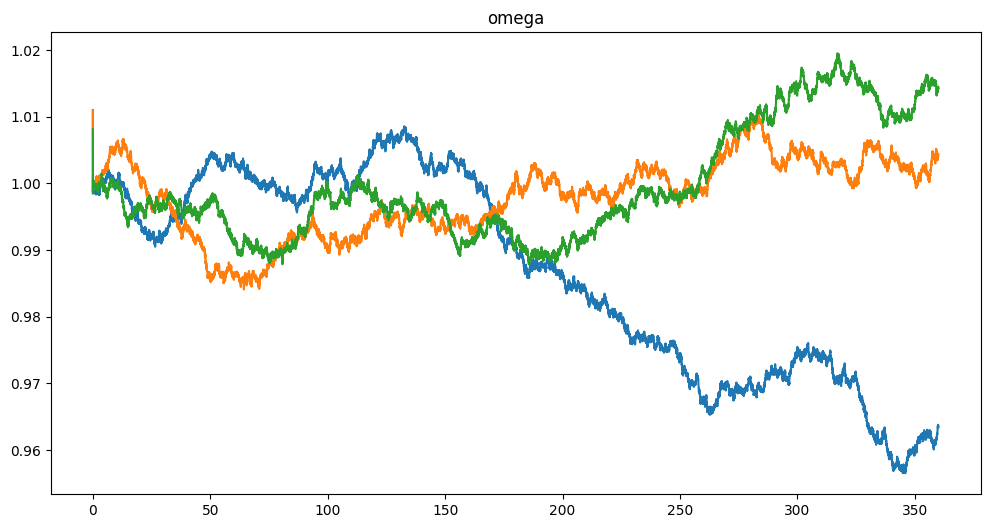

In [15]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,0])
plt.plot(time, state_est_hist[:,1])
plt.plot(time, state_est_hist[:,2])
plt.title("omega")

Text(0.5, 1.0, 'omega dot')

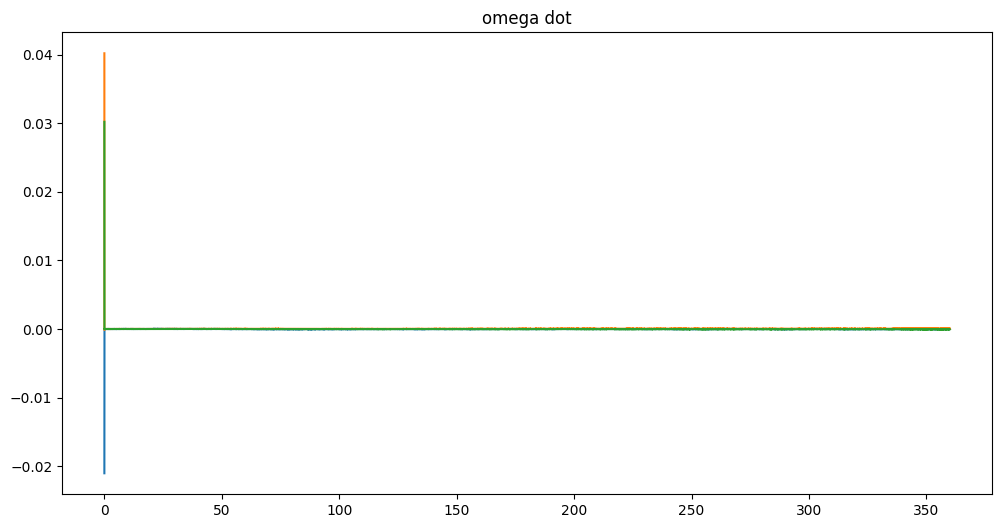

In [16]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,3])
plt.plot(time, state_est_hist[:,4])
plt.plot(time, state_est_hist[:,5])
plt.title("omega dot")

Text(0.5, 1.0, 'Specific force')

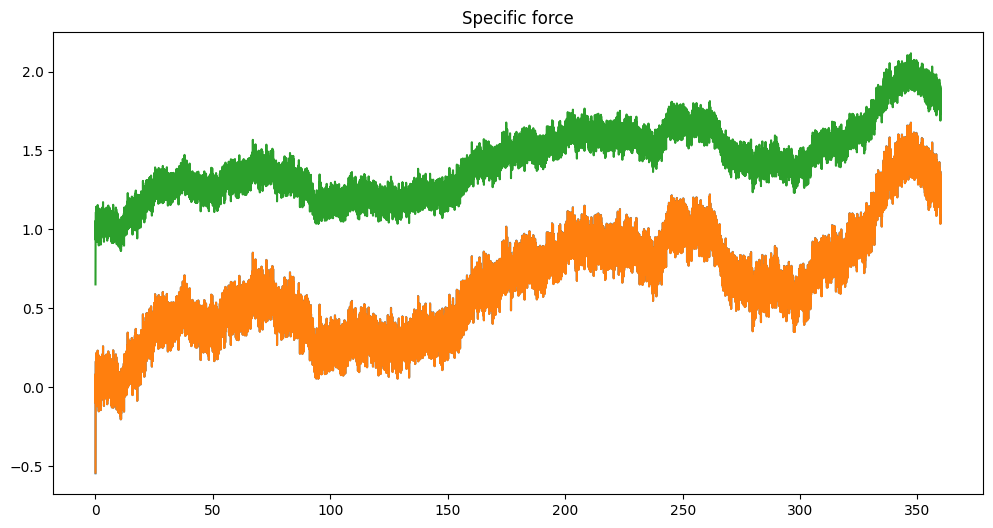

In [17]:
plt.figure(figsize = (12, 6))
plt.plot(time, state_est_hist[:,6])
plt.plot(time, state_est_hist[:,7])
plt.plot(time, state_est_hist[:,8])
plt.title("Specific force")